In [1]:
import os
import pandas as pd
import numpy as np
import pickle

# TMB, 390 have count and image

In [2]:
all_svs = [os.path.splitext(i)[0] for i in os.listdir('/home/Tsung/pathology/data/tcga/svs')]
all_patches = [i for i in os.listdir('/home/Tsung/pathology/data/tcga/patches')]
no_patches = []
for i in all_svs:
    if i not in all_patches:
        no_patches.append(i)
print(len(all_svs), len(all_patches), len(no_patches))

711 711 0


In [3]:
cohort_patches = {i[:12] : 0 for i in sorted(os.listdir('/home/Tsung/pathology/data/tcga/patches/'))}
print(len(cohort_patches))

390


In [4]:
mutation_count = pd.read_csv('./data/coad_Mutation_Count.txt', delimiter="\t")
cohort_count_dict = {row[1]: row[3] for index,row in mutation_count.iterrows()}
print(len(cohort_count_dict))

528


In [5]:
non_empty = []
empty = []
for key, value in cohort_count_dict.items():
    if key not in list(cohort_patches.keys()):
        empty.append(key)
    else:    
        non_empty.append(key)
print("empty: {}, non empty: {}".format(len(empty), len(non_empty)))

empty: 138, non empty: 390


# tumor grade, 363 有值

In [6]:
# 有重複的人，但class是一樣的
tumor_grade = pd.read_csv("/home/Tsung/pathology/data/tcga/Tumor grading.csv")
tumor_grade.dropna(subset=["TCGA-ID"], inplace=True)
tumor_grade.dropna(subset=["Class"], inplace=True)
# # replace nan
# tumor_grade['Class'] = tumor_grade['Class'].replace(np.nan, -10000)

In [7]:
cohort_tumor_grade_dict = {i: -1 for i in non_empty}
for index, row in tumor_grade.iterrows():
    cohort = row[1][:12]
    grade = row[2]
    if cohort in list(cohort_tumor_grade_dict.keys()):
        cohort_tumor_grade_dict[cohort] = int(grade)

### one hot, nan 給全 0

In [8]:
_temp = {}
for key, value in cohort_tumor_grade_dict.items():
    if value == 1:
        one_hot = np.array([1, 0])
    elif value == 2:
        one_hot = np.array([0, 1])
    else:
        one_hot = np.zeros(2)
    _temp[key] = one_hot
cohort_tumor_grade_dict = _temp
del _temp

In [9]:
tumor_grade_nan_cohort = []
for cohort, value in cohort_tumor_grade_dict.items():
    if value.sum() == 0:
        tumor_grade_nan_cohort.append(cohort)
print("total : {}\nNaN : {}".format(len(cohort_tumor_grade_dict), len(tumor_grade_nan_cohort)))

total : 390
NaN : 27


### 不做one hot

In [9]:
tumor_grade_nan_cohort = []
for cohort, value in cohort_tumor_grade_dict.items():
    if value == -1:
        tumor_grade_nan_cohort.append(cohort)
print("total : {}\nNaN : {}".format(len(cohort_tumor_grade_dict), len(tumor_grade_nan_cohort)))

total : 390
NaN : 27


# side info, only 388

In [10]:
clinical = pd.read_csv('/home/Tsung/pathology/data/tcga/clinical/nationwidechildrens.org_clinical_patient_coad.txt', delimiter="\t")
clinical = clinical.drop(clinical.index[[0,1]])

In [11]:
drop_index = []
for idx, barcode in zip(clinical['bcr_patient_barcode'].index, clinical['bcr_patient_barcode']):
    if barcode not in non_empty:
        drop_index.append(idx)
clinical.drop(drop_index , inplace=True)

In [12]:
# 390 裡面缺 2 個
print("has image, but no side info")
side_info_nan_cohort = []
drop_index = []
for i in non_empty:
    if i not in list(clinical['bcr_patient_barcode']):
        print("{} {}".format(i, cohort_count_dict[i]))
        side_info_nan_cohort.append(i)

has image, but no side info
TCGA-5M-AAT5 79
TCGA-5M-AATA 71


In [13]:
useless = ['bcr_patient_uuid', 'bcr_patient_barcode', 'form_completion_date', 'birth_days_to', 'last_contact_days_to',
           'death_days_to', 'initial_pathologic_dx_year', 'days_to_initial_pathologic_diagnosis', 'ajcc_staging_edition', 'lymph_nodes_examined', 'weight_kg_at_diagnosis',
           'height_cm_at_diagnosis', 'icd_o_3_site', 'informed_consent_verified', 'patient_id', 'tumor_tissue_site', 'icd_o_3_histology',
          'prospective_collection', 'retrospective_collection', 'ethnicity', 'history_neoadjuvant_treatment',
          'vascular_invasion_indicator', 'lymphovascular_invasion_indicator', 'kras_gene_analysis_indicator', 'mismatch_rep_proteins_tested_by_ihc',
          'braf_gene_analysis_indicator', 'age_at_initial_pathologic_diagnosis', 'tumor_tissue_site', 'tissue_source_site', 'colon_polyps_at_procurement_indicator',
          'lymph_nodes_examined_he_count', 'lymph_nodes_examined_count', 'vital_status', 'icd_10']
nan_strings = ["[Not Available]", "[Not Applicable]", "[Unknown]", "[Not Evaluated]", "[Discrepancy]"]

In [14]:
# replace all nan to None
for i in nan_strings:
    clinical = clinical.replace(i, 'None')

### choose feature

In [15]:
use_col_name = []
for col_name in clinical.columns:
    if col_name in useless:
        continue
    nan_value_number = len(clinical.loc[clinical[col_name] == 'None'])
        
    if nan_value_number > len(clinical)*0.5:
        continue
    print(col_name)
    use_col_name.append(col_name)
    for i in sorted(clinical[col_name].unique()):
        print("\t{} : {}".format(i, len(clinical.loc[clinical[col_name] == i])))
    print('\n')

histologic_diagnosis
	Colon Adenocarcinoma : 328
	Colon Mucinous Adenocarcinoma : 56
	None : 4


gender
	FEMALE : 187
	MALE : 201


race
	AMERICAN INDIAN OR ALASKA NATIVE : 1
	ASIAN : 11
	BLACK OR AFRICAN AMERICAN : 55
	None : 122
	WHITE : 199


history_other_malignancy
	No : 348
	Yes : 39
	Yes, History of Synchronous/Bilateral Malignancy : 1


ajcc_tumor_pathologic_pt
	T1 : 9
	T2 : 70
	T3 : 261
	T4 : 20
	T4a : 19
	T4b : 8
	Tis : 1


ajcc_nodes_pathologic_pn
	N0 : 231
	N1 : 60
	N1a : 15
	N1b : 14
	N1c : 2
	N2 : 45
	N2a : 8
	N2b : 13


ajcc_metastasis_pathologic_pm
	M0 : 282
	M1 : 40
	M1a : 8
	M1b : 3
	MX : 49
	None : 6


ajcc_pathologic_tumor_stage
	None : 11
	Stage I : 66
	Stage IA : 1
	Stage II : 23
	Stage IIA : 118
	Stage IIB : 8
	Stage IIC : 1
	Stage III : 18
	Stage IIIA : 7
	Stage IIIB : 50
	Stage IIIC : 34
	Stage IV : 34
	Stage IVA : 15
	Stage IVB : 2


residual_tumor
	None : 64
	R0 : 279
	R1 : 4
	R2 : 17
	RX : 24


tumor_status
	None : 50
	TUMOR FREE : 187
	WITH TUMOR : 151


ce

### 標準化 table, nan 算一個class || 不把nan算一個class, 給負無限大

In [16]:
inference_table = clinical[use_col_name].copy()
feature_table = clinical[use_col_name].copy()

continuous_feature = ['lymph_nodes_examined_count', 'lymph_nodes_examined_he_count', 'cea_level_pretreatment']
for col_name in inference_table.columns:
    # mapping feature to index
    # 不把 None 算是一個 class
    all_options_in_one_feature = sorted(list(inference_table[col_name].unique()))
    if 'None' in all_options_in_one_feature:
        all_options_in_one_feature.remove('None')
    all_options_in_one_feature = {key: idx for idx, key in enumerate(all_options_in_one_feature)}
    
    # replace discrete with index, continous remain continous
    new_content = []
    if col_name not in continuous_feature:
        for val in np.array(inference_table[col_name]):
            if val == 'None':
                new_content.append(-1)
            else:
                new_content.append(all_options_in_one_feature[val])
    else:
        for val in np.array(inference_table[col_name]):
            if val != "None":
                new_content.append(float(val))
            else:
                new_content.append(-1)
    # replace by new content
    feature_table[col_name] = new_content
    
del inference_table

### one hot, nan 算一個class

In [17]:
feature_table['bcr_patient_barcode'] = clinical['bcr_patient_barcode']
cohort_side_info_dict = {i: np.array([]) for i in sorted(feature_table['bcr_patient_barcode'])}
col_names = feature_table.columns
for idx, row in feature_table.iterrows():
    cohort_name = row['bcr_patient_barcode']
    
    for col_name in col_names[:-1]:
        if col_name not in continuous_feature:
            num = len(clinical[col_name].unique())
            one_hot = np.eye(num)[row[col_name]]
            cohort_side_info_dict[cohort_name] = np.append(cohort_side_info_dict[cohort_name], one_hot)
            
        else:
            cohort_side_info_dict[cohort_name] = np.append(cohort_side_info_dict[cohort_name], np.array([row[col_name]]))


### 不做 one hot

In [25]:
feature_table['bcr_patient_barcode'] = clinical['bcr_patient_barcode']
cohort_side_info_dict = {i: np.array([]) for i in sorted(feature_table['bcr_patient_barcode'])}
col_names = feature_table.columns
for idx, row in feature_table.iterrows():
    cohort_name = row['bcr_patient_barcode']
    
    for col_name in col_names[:-1]:
        cohort_side_info_dict[cohort_name] = np.append(cohort_side_info_dict[cohort_name], np.array([row[col_name]]))


# transcriptomics 381 有值

In [17]:
with open('/home/Tsung/pathology/data/tcga/transcriptomics.pkl', 'rb') as fp:
    cohort_trans_dict = pickle.load(fp)

In [18]:
# 390 裡面缺 6 個
trans_nan_cohort = []
for i in non_empty:
    if i not in cohort_trans_dict.keys():
        print(i)
        trans_nan_cohort.append(i)

TCGA-AA-3521
TCGA-AA-3558
TCGA-AA-3695
TCGA-AZ-4681
TCGA-5M-AAT5
TCGA-5M-AATA


# transcriptomics, side info, mutation grade 缺的人

In [19]:
_temp = trans_nan_cohort + tumor_grade_nan_cohort + side_info_nan_cohort
_temp = set(_temp)

In [20]:
loss_cohort = {val: np.zeros(3) for val in _temp}
for i in trans_nan_cohort:
    loss_cohort[i][0] += 1
for i in tumor_grade_nan_cohort:
    loss_cohort[i][1] += 1
for i in side_info_nan_cohort:
    loss_cohort[i][2] += 1
print(len(loss_cohort))

33


In [21]:
for i in loss_cohort.keys():
    print(i, ":", cohort_count_dict[i])

TCGA-A6-5659 : 202
TCGA-AA-3521 : 17
TCGA-A6-5656 : 107
TCGA-AA-A02O : 159
TCGA-AA-A01T : 90
TCGA-A6-2681 : 131
TCGA-AA-3558 : 16
TCGA-AA-3695 : 147
TCGA-DM-A0XF : 112
TCGA-5M-AATA : 71
TCGA-AZ-4681 : 79
TCGA-DM-A0X9 : 170
TCGA-A6-6780 : 1177
TCGA-AA-3666 : 169
TCGA-D5-6534 : 152
TCGA-AA-A02Y : 110
TCGA-D5-6540 : 1191
TCGA-CA-6718 : 3205
TCGA-A6-2677 : 117
TCGA-G4-6317 : 86
TCGA-A6-2683 : 33
TCGA-AA-A03F : 126
TCGA-AA-A01S : 51
TCGA-A6-3809 : 1166
TCGA-A6-3810 : 166
TCGA-AA-3956 : 135
TCGA-DM-A0XD : 155
TCGA-AA-3984 : 5116
TCGA-5M-AAT5 : 79
TCGA-AM-5821 : 1205
TCGA-A6-2684 : 99
TCGA-DM-A28C : 99
TCGA-AA-A01R : 1621


# conbine feature

In [31]:
final_feature = {}
for cohort in non_empty:
    if cohort in loss_cohort:
        continue
    final_feature[cohort] = []
print(len(final_feature))

357


In [35]:
for key, value in final_feature.items():
    final_feature[key] = cohort_tumor_grade_dict[key]
print(len(final_feature))

357


In [36]:
for key, value in final_feature.items():
    final_feature[key] = np.concatenate((final_feature[key], cohort_side_info_dict[key]))

In [41]:
for key, value in final_feature.items():
    final_feature[key] = np.concatenate((final_feature[key], cohort_trans_dict[key]))

In [42]:
for key, value in final_feature.items():
    print(key, len(value))

TCGA-3L-AA1B 60500
TCGA-4N-A93T 60500
TCGA-4T-AA8H 60500
TCGA-5M-AAT4 60500
TCGA-5M-AAT6 60500
TCGA-5M-AATE 60500
TCGA-A6-2671 60500
TCGA-A6-2674 60500
TCGA-A6-2675 60500
TCGA-A6-2678 60500
TCGA-A6-2685 60500
TCGA-A6-2686 60500
TCGA-A6-3807 60500
TCGA-A6-3808 60500
TCGA-A6-4105 60500
TCGA-A6-4107 60500
TCGA-A6-5657 60500
TCGA-A6-5660 60500
TCGA-A6-5661 60500
TCGA-A6-5662 60500
TCGA-A6-5664 60500
TCGA-A6-5665 60500
TCGA-A6-5666 60500
TCGA-A6-5667 60500
TCGA-A6-6137 60500
TCGA-A6-6138 60500
TCGA-A6-6142 60500
TCGA-A6-6648 60500
TCGA-A6-6649 60500
TCGA-A6-6651 60500
TCGA-A6-6652 60500
TCGA-A6-6653 60500
TCGA-A6-6654 60500
TCGA-A6-6781 60500
TCGA-A6-6782 60500
TCGA-A6-A565 60500
TCGA-A6-A566 60500
TCGA-A6-A567 60500
TCGA-A6-A56B 60500
TCGA-AA-3489 60500
TCGA-AA-3492 60500
TCGA-AA-3496 60500
TCGA-AA-3502 60500
TCGA-AA-3506 60500
TCGA-AA-3510 60500
TCGA-AA-3511 60500
TCGA-AA-3514 60500
TCGA-AA-3517 60500
TCGA-AA-3519 60500
TCGA-AA-3520 60500
TCGA-AA-3522 60500
TCGA-AA-3524 60500
TCGA-AA-3526

# save file

In [52]:
# with open('./other_feature.pkl', 'wb') as file:
#     pickle.dump(final_feature, file)

In [38]:
# with open('./no_RNA_no_onehot_other_feature.pkl', 'wb') as file:
#     pickle.dump(final_feature, file)

In [43]:
# with open('./no_onehot_other_feature.pkl', 'wb') as file:
#     pickle.dump(final_feature, file)

# positional

In [ ]:
# all_folders = os.listdir(os.path.join(DATA_FOLDER, "1000dense200"))
# all_images = glob.glob(os.path.join(DATA_FOLDER, "1000dense200", all_folders[0], '*.jpg'))

# coor_x_list = []
# coor_y_list = []

# for image in all_images:
#     image_name = image.split('/')[-1]
#     image_name, jpg = os.path.splitext(image_name)
#     coor_x, coor_y = image_name.split('_')[1], image_name.split('_')[2]
#     coor_x_list.append(int(coor_x))
#     coor_y_list.append(int(coor_y))

# coor_x_set = list(set(coor_x_list))
# coor_y_set = list(set(coor_y_list))

# image_position = np.zeros((len(coor_y_set), len(coor_x_set)))

# for y, x in zip(coor_y_list, coor_x_list):
#     std_coor_y = coor_y_set.index(y)
#     std_coor_x = coor_x_set.index(x)
#     image_position[std_coor_y][std_coor_x] = 1
    
# plt.imshow(image_position)
# plt.colorbar()

# image

In [68]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def rgb2hsv(image):
    return image.convert('HSV')

In [64]:
lalala = "/home/Tsung/pathology/data/tcga/patches/TCGA-F4-6459-01A-01-TS1.424790bd-471f-4312-b54d-361ea302deda/TCGA-F4-6459-01A-01-TS1.424790bd-471f-4312-b54d-361ea302deda_0_17500_1.jpg"
name = "/home/Tsung/pathology/data/tcga/patches/TCGA-3L-AA1B-01A-01-TS1.9C415218-D5B4-4945-B243-F42A4C8C0484/TCGA-3L-AA1B-01A-01-TS1.9C415218-D5B4-4945-B243-F42A4C8C0484_6977_19124_1269.jpg"
foo = "/home/Tsung/pathology/data/tcga/patches/TCGA-F4-6459-01A-01-TS1.424790bd-471f-4312-b54d-361ea302deda/TCGA-F4-6459-01A-01-TS1.424790bd-471f-4312-b54d-361ea302deda_0_34000_15.jpg"

In [72]:
# image = Image.open(foo)
image = cv2.imread(foo)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

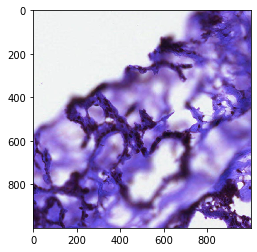

In [73]:
plt.imshow(image)

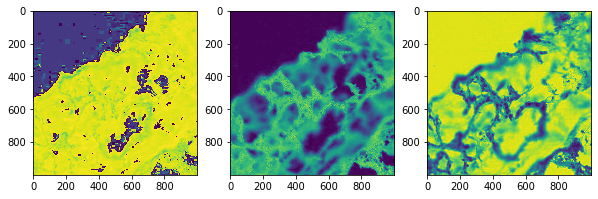

In [75]:
plt.figure(figsize=(10, 30))
plt.subplot(1,3,1)
plt.imshow(hsv[:,:,0])
plt.subplot(1,3,2)
plt.imshow(hsv[:,:,1])
plt.subplot(1,3,3)
plt.imshow(hsv[:,:,2])